In [1]:
import numpy as np

import requests 
import json 
import pandas as pd 
import string 
import re 
import matplotlib.pyplot as plt 
import sklearn 
from sklearn.metrics import confusion_matrix , accuracy_score , f1_score
import pickle

# REDDIT DATA COLLECTION

#### I used PUSHSHIFT.IO API instead of PRAW as praw had certain limits on the number of data values. PRAW doesn't provide access to more than 1000 records

In [2]:
def getPushshiftData(sub=None, before=None, after=None, ids=None, getSubmissions=True, getComments=False):
    suffix=''
    searchType = 'submission'
    if getComments or not getSubmissions:
        searchType='comment'
    if (before is not None):
        suffix += '&before='+str(before)
    if (after is not None):
        suffix += '&after='+str(after)
    if (sub is not None):
        suffix += '&subreddit='+sub
    if (ids is not None):
        suffix += '&ids='+','.join(ids)

    url = 'https://api.pushshift.io/reddit/search/'+searchType+'?sort=desc&size=1500'+suffix
    r = requests.get(url)
    data = json.loads(r.content)
    if len(data['data']) > 0:
        prev_end_date = data['data'][-1]['created_utc']
    else:
        prev_end_date = None
    return (data, prev_end_date)

#### The time have been set to 120 days which results in collection of around 50000-60000 titles

In [3]:
sub='India'
(submissions_tmp, prev_end_date) = getPushshiftData(sub=sub, after='120d')
submissions = submissions_tmp['data']
while prev_end_date is not None:
    try:
        (submissions_tmp, prev_end_date) = getPushshiftData(sub=sub, before=prev_end_date-1, after='120d')
        if prev_end_date is not None:
            submissions.extend(submissions_tmp['data'])
    except:
        continue

In [4]:
submission =[]
for post in submissions:
    submission.append(post)

In [5]:
submission_df=pd.DataFrame(submission)

In [6]:
df1 = pd.concat([submission_df['title'],submission_df['link_flair_text']], axis = 1)

# Exploratory Data Analysis

In [7]:
df1 = df1.dropna()

In [8]:
pd.set_option('display.max_colwidth', 100)
df = df1.copy()
df['flair'] = df['link_flair_text']
df= df.drop(['link_flair_text'], axis = 1)
df

,title,flair
0,"Salaries of Meghalaya ministers, bureaucrats deferred by 50% due Covid-19",Politics
2,Decoded: How gold may benefit from coronavirus crisis,Business/Finance
3,"US panel flags India’s ‘sharp, alarming’ decline in religious freedom, suggests ‘targeted sancti...",Politics
4,Actor Irrfan Khan admitted to hospital as health deteriorates,Non-Political
5,Niti Aayog questions Australian institute’s terror ranking of India,Policy/Economy
...,...,...
58646,The whole truth,Politics
58648,#HinduRashtraRow | Fact-check for Sadhguru.,Politics
58649,Should you support CAA?,Politics
58650,S10+ compatibility,Science/Technology


In [9]:
flair_set = set(df['flair'])

In [10]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [11]:
df.groupby('flair').count()['title'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8,title='Bar chart of Department Name', xTitle='Department Name')

##### IT WAS FOUND THAT THE DATA WAS HIGHLY BIASED .
MORE THAN 50% DATA WAS COMPRISED OF JUST 4 CLASSES.
SEPERATED THE 10 MOST FREQUENT FLAIRS & ENLISTED THEM IN LIST CALLED FLAIR2KEEP .
ALL OTHER CLASSES WERE DROPPED AS IT WOULD BE DIFFICULT FOR THE MODEL TO WORK WITH SO MANY CLASSES

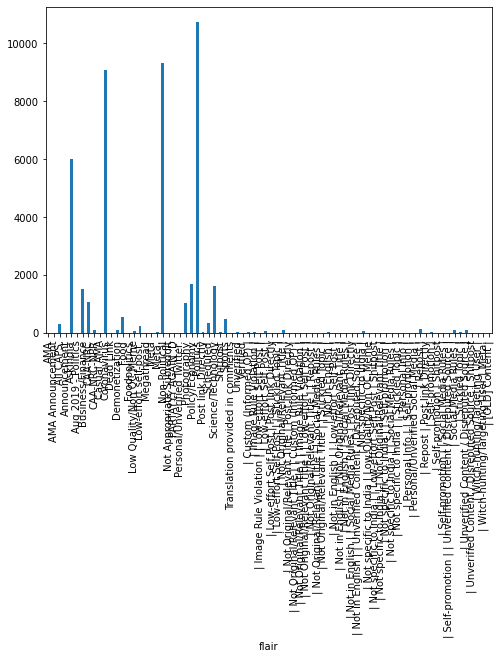

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('flair').title.count().plot.bar(ylim=0)
plt.show()

#### 10 MOST FREQUENT CLASSES WERE KEPT & REST OF THEM WERE DROPPED


In [13]:
flairs2keep = df1['link_flair_text'].value_counts()[:10].index.tolist()
flairs2keep

['Politics',
 'Non-Political',
 'Coronavirus',
 'AskIndia',
 'Policy/Economy',
 'Science/Technology',
 'Business/Finance',
 'CAA-NRC',
 'Photography',
 'Food']

In [14]:
for f in flair_set:
    if f not in flairs2keep:
        df = df[df.flair != f]
    else :
        continue

In [15]:
set(df['flair'])

{'AskIndia',
 'Business/Finance',
 'CAA-NRC',
 'Coronavirus',
 'Food',
 'Non-Political',
 'Photography',
 'Policy/Economy',
 'Politics',
 'Science/Technology'}

### BALANCING THE BIASED DATA

##### It was observed that the data collected was biased. On analysing the number of count 

##### i found that the class with minimum count had 500(appx) values whereas the rest lower 5 varied from 1000-1500. I decided it would be fair enough to resample the data to a value of 2000 per class.

#####  2000 DATA VALUES FROM EACH CLASS WERE EXPLICILY TAKEN BY PERFORMING OVER OR UNDERSAMPLING ACCORDINGLY

In [16]:
flairs_count = {'flair' : [] , 'count' : []}
for flair in flairs2keep:
    count = np.sum(df.loc[:, 'flair'].values == flair)
    flairs_count['flair'].append(flair)
    flairs_count['count'].append(count)
pd.DataFrame(flairs_count)

,flair,count
0,Politics,10734
1,Non-Political,9320
2,Coronavirus,9091
3,AskIndia,6000
4,Policy/Economy,1688
5,Science/Technology,1619
6,Business/Finance,1526
7,CAA-NRC,1070
8,Photography,1022
9,Food,546


In [17]:
corona_df = df[df.flair == 'Coronavirus']
np_df     = df[df.flair == 'Non-Political']
p_df      = df[df.flair == 'Politics']
ask_df    = df[df.flair == 'AskIndia']
food_df   = df[df.flair == 'Food']
tech_df   = df[df.flair == 'Science/Technology']
econ_df   = df[df.flair == 'Policy/Economy']
fin_df    = df[df.flair == 'Business/Finance']
caa_df    = df[df.flair == 'CAA-NRC']
photo_df  = df[df.flair == 'Photography']

In [18]:
from sklearn.utils import resample

corona_bal = resample(corona_df,
                          replace = False, 
                          n_samples = 2000, 
                          random_state = 27)
np_bal = resample(np_df,
                          replace = False,
                          n_samples = 2000, 
                          random_state = 27)
p_bal = resample(p_df,
                          replace = False, 
                          n_samples = 2000, 
                          random_state = 27)
ask_bal = resample(ask_df,
                          replace = False, 
                          n_samples = 2000, 
                          random_state = 27)

photo_bal =  resample(photo_df,
                          replace = True, 
                          n_samples = 2000, 
                          random_state = 27)
food_bal  =  resample(food_df,
                          replace = True, 
                          n_samples = 2000, 
                          random_state = 27)
tech_bal  =  resample(tech_df,
                          replace = True, 
                          n_samples = 2000, 
                          random_state = 27)
econ_bal = resample(econ_df,
                          replace = True,
                          n_samples = 2000, 
                          random_state = 27)
fin_bal = resample(fin_df,
                          replace = True, 
                          n_samples = 2000, 
                          random_state = 27)
caa_bal = resample(caa_df,
                          replace = True, 
                          n_samples = 2000,
                          random_state = 27)



In [19]:
df_2 = pd.concat([caa_bal,econ_bal,fin_bal,tech_bal,food_bal,ask_bal,photo_bal,p_bal,np_bal,corona_bal ])

In [20]:
flairs_count = {'flair' : [] , 'count' : []}
for flair in flairs2keep:
    count = np.sum(df_2.loc[:, 'flair'].values == flair)
    flairs_count['flair'].append(flair)
    flairs_count['count'].append(count)
pd.DataFrame(flairs_count)

,flair,count
0,Politics,2000
1,Non-Political,2000
2,Coronavirus,2000
3,AskIndia,2000
4,Policy/Economy,2000
5,Science/Technology,2000
6,Business/Finance,2000
7,CAA-NRC,2000
8,Photography,2000
9,Food,2000


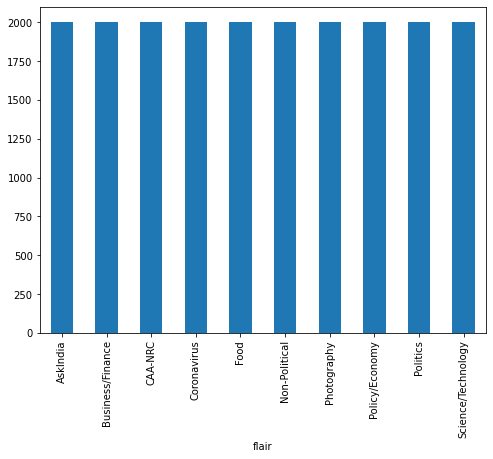

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_2.groupby('flair').title.count().plot.bar(ylim=0)
plt.show()

In [22]:
df_3 = df.copy()
df = df_2

In [23]:
set_flair = set(df['flair'])

## PREPROCESSING

#####  AS A PART OF PREPROCESSING
NUMBERS , PUNCTUATIONS , EMOJIS , STOPWORDS WERE REMOVED FROM THE TEXT.
LEMMATIZATION OF TEXT WAS DONE INSTEAD OF STEMMING. ALSO, TOKENIZATION OF DATA WAS ALSO DONE

I USED REGULAR EXPRESSIONS & NLTK LIBRARY TO PREPROCESS THE DATA

I prefered lemmatization over because stemmers reduce the word to its root form by removing the suffix and the result may or may not hold meaning whereas lemmatizatio resulted in meaniful root words.

I had to use these words to use glove embedding further in the process therefore the words had to meaningful moreove lemmatizers also keep track of synonyms therefore reducing the dimensionality

In [24]:
def no_num(text):
    text = re.sub('[0-9]+', '', text)
    return text

def no_punc(text):
    #nopuncmsg = ''.join([c for c in text if c not in string.punctuation])
    text = re.sub(r'[^\w\s]',' ',text)
    text = re.sub(' +', ' ', text)
    return text

In [25]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

In [26]:
tokenized = []
def tokenizer(text):
    tokenized = word_tokenize(text)
    return tokenized
remov_stop_words = []
def remov_stopwords(text):
    remov_stop_words  =' '.join([c for c in text.split(' ') if c not in stopwords.words('english')])
    return remov_stop_words
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
def func_lemmatizer(text):
    lemmatized = []
    lemmatizer = WordNetLemmatizer()
    lemmatized = ' '.join( [ lemmatizer.lemmatize(word) for word in text] )
    return lemmatized

In [27]:
index_perm = np.random.permutation(df.index)

In [28]:
df = df.sample(frac=1).reset_index(drop=True)
df.head(20)

,title,flair
0,Coughing cat meme know your meme | FoxyDoor.Com,Business/Finance
1,Online Food Delivery- IRCTC eCatering Travel Food Services India,Food
2,"Economic Times on Twitter: ""#DelhiPolice seeks permission from the #Delhi Govt to convert a stad...",CAA-NRC
3,Will the Bihar BJP also be called ‘anti-national’ for resolution against the NRC?,CAA-NRC
4,Coronavirus update: India quarantines itself from world for a month to fight coronavirus | India...,Non-Political
5,Pakistan groups trying to send 200 terrorists - Around 160 terrorists of the Lashkar-e-Taiba (Le...,Politics
6,"[OC] DJI Mavic Mini, 2.7k 30fps, Thiruvanmiyur",Photography
7,Sunrise over a Goan suburb on the 21st day of the nationwide lockdown : 1193 recovered cases [35...,Photography
8,Mumbai Police on Today's Horoscope,Coronavirus
9,Is Ghee The Reason Most of the Indians have Round Belly?,AskIndia


In [29]:
text = df['title']

In [30]:
def preprocessor(text):
    text = text.str.lower()
    text = text.apply(no_num)
    text = text.apply(no_punc)
    text = text.apply(remov_stopwords)
    text = text.apply(deEmojify)
    text = text.apply(tokenizer)
    text = text.apply(func_lemmatizer)
    return text

In [31]:
text = preprocessor(df['title'])
df['title'] = text
df

,title,flair
0,coughing cat meme know meme foxydoor com,Business/Finance
1,online food delivery irctc ecatering travel food service india,Food
2,economic time twitter delhipolice seek permission delhi govt convert stadium temporary prison an...,CAA-NRC
3,bihar bjp also called anti national resolution nrc,CAA-NRC
4,coronavirus update india quarantine world month fight coronavirus india news time india,Non-Political
...,...,...
19995,covid patient go kerala govt release map,Policy/Economy
19996,kashmir govt slash salary college contractual lecturer percent,Policy/Economy
19997,hand roll roti feed poor,Food
19998,government compensate daily wage earner loss due coronavirus,Coronavirus


##### I MADE MY OWN DICTIONARY WHICH WAS FURTHER USED IN BUILDING LSTM LANGUAGE MODEL. THE MODEL SCRAPES THROUGH THE WHOLE TEXT AND ASSIGNS AN INDEX TO EACH UNIQUE WORD & ALSO MANTAING THE WORD COUNT

In [32]:
SOS_token = 0
EOS_token = 1
word2count = {}
word2index = {}
index2word = {}
n_words =  [0]

In [33]:
def addword(word , n_words , word2count , word2index , index2word ):
    if word not in word2index:
        word2index[word] = n_words[0]
        index2word[ n_words[0] ] = word
        word2count[word] = 1
        n_words[0] = n_words[0] + 1
    else:
        word2count[word] +=1

def addtext( sentence ,n_words , word2count , word2index , index2word ):
        for word in sentence.split(' '):
            addword(word , n_words , word2count , word2index , index2word )

In [34]:
df_1 = df.copy()
df_1['title'] = df_1['title'].apply( addtext , args = (n_words , word2count , word2index , index2word) )

In [35]:
len(word2index)

15490

#### SEPERATE DICTIONARY FOR FLAIRS

In [36]:
index2flair={}
flair2index ={}
for k , flair in enumerate(set(df['flair'])):
    index2flair[k] = flair
    flair2index[flair] = k

In [37]:
flair2index

{'AskIndia': 0,
 'Policy/Economy': 1,
 'Business/Finance': 2,
 'Photography': 3,
 'Politics': 4,
 'Coronavirus': 5,
 'Science/Technology': 6,
 'Non-Political': 7,
 'CAA-NRC': 8,
 'Food': 9}

## ML MODELS

In [38]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer , TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB , MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, linear_model, metrics

In [39]:
target_index = []
target_names = []

In [40]:
for flair in df['flair']:
    target_index.append(flair2index[str(flair)])
    target_names.append(flair)

In [41]:
corpus = []
for title in df['title']:
    corpus.append(title)

#### SPLITTING DATA FOR TESTING AND TRAINING . I TOOK ONLY 20% DATA AS TESTING DATA. AS I ALREADY HAD LESS DATA

In [42]:
train_x , test_x , train_y , test_y = train_test_split(corpus , target_names , test_size = 0.2)

### COUNTER VECTORIZER

IS A LIBRARY WHICH GIVES A DICTIONARY , VOCABULARY , WORD COUNTS OF THE CORPUS(INPUT) AS OUTPUT.

In [43]:
cv = CountVectorizer()
X = cv.fit(train_x)
#X.vocabulary
#X.get_feature_names()
counts = cv.transform(train_x)
print(counts.shape)
#counts.toarray()

(16000, 14242)


##### I USED PICKLE TO SAVE THE TRAINED MODEL & LOAD IT WHEN REQUIRED.

In [44]:
Pkl_Filename = "Pickle_CV_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(cv, file)

### TFIDF TRANSFORMER

ASSIGNS WEIGHTS TO THE WORDS ACCORDING TO THEIR FREQUENCY IN THE TEXT.
SO IF STOP WORDS LEFT WILL BE GIVEN THE MOST WEIGHTAGE

In [45]:
tf = TfidfTransformer()
X_tfidf = tf.fit_transform(counts)
print('learning frequency of all features :' + str(tf.idf_) + '\n\n')
freq = tf.transform(counts)
print(freq.toarray())

learning frequency of all features :[9.98725932 9.98725932 9.98725932 ... 9.98725932 9.98725932 9.98725932]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##### SAVING THE TFIDF MODEL ON PICKLE

In [46]:
Pkl_Filename = "Pickle_TF_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(tf, file)

#### I TRIED TO PREDICT WHICH MODEL WILL WORK BETTER ON THE FOLLOWING DATA

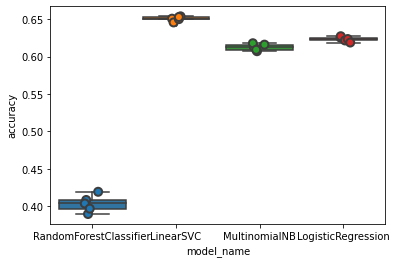

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0 , max_iter = 5000),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_tfidf, train_y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [48]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.650563
LogisticRegression        0.623250
MultinomialNB             0.612625
RandomForestClassifier    0.403625
Name: accuracy, dtype: float64

### LOGISTIC REGRESSION

ASSGNS OBSERVATIONS FOR DISCRETE CLASSES .
IT IS BASED ON STATISTICAL APPROACHES & IS VULNERABLE TO OVERFITTING BECAUSE OF IT

In [49]:
lr = LogisticRegression(max_iter = 5000)
x_lr = lr.fit(X_tfidf, train_y)
x_test_tf = cv.transform(test_x)
x_test_tfidf = tf.transform(x_test_tf)
predicted = lr.predict(x_test_tfidf)
print("accuracy : ", accuracy_score(test_y,predicted) )
print(metrics.classification_report(test_y,predicted , target_names = set_flair))
metrics.confusion_matrix(test_y , predicted)

accuracy :  0.64025
                    precision    recall  f1-score   support

          AskIndia       0.44      0.39      0.42       393
    Policy/Economy       0.70      0.71      0.70       387
  Business/Finance       0.75      0.83      0.79       412
       Photography       0.58      0.61      0.59       399
           CAA-NRC       0.86      0.90      0.88       394
          Politics       0.32      0.27      0.30       403
       Coronavirus       0.74      0.84      0.79       393
Science/Technology       0.67      0.65      0.66       424
     Non-Political       0.57      0.49      0.53       408
              Food       0.64      0.72      0.68       387

          accuracy                           0.64      4000
         macro avg       0.63      0.64      0.63      4000
      weighted avg       0.63      0.64      0.63      4000



array([[154,  25,   5,  36,  12,  58,  15,  20,  30,  38],
       [ 19, 273,   1,  13,   5,  16,   7,  25,   5,  23],
       [ 13,   6, 341,   0,   2,  15,   1,   3,  29,   2],
       [ 27,   5,   6, 242,   8,  41,  12,  15,  22,  21],
       [  7,   1,   2,   4, 354,   1,  12,   2,   5,   6],
       [ 60,  16,  19,  52,   9, 110,  47,  25,  29,  36],
       [  9,   7,   4,  11,   2,  15, 331,   4,   7,   3],
       [ 14,  33,  10,  29,   4,  23,   2, 276,  18,  15],
       [ 19,   8,  66,  18,   7,  40,  14,  24, 201,  11],
       [ 26,  14,   1,  10,   9,  23,   5,  15,   5, 279]])

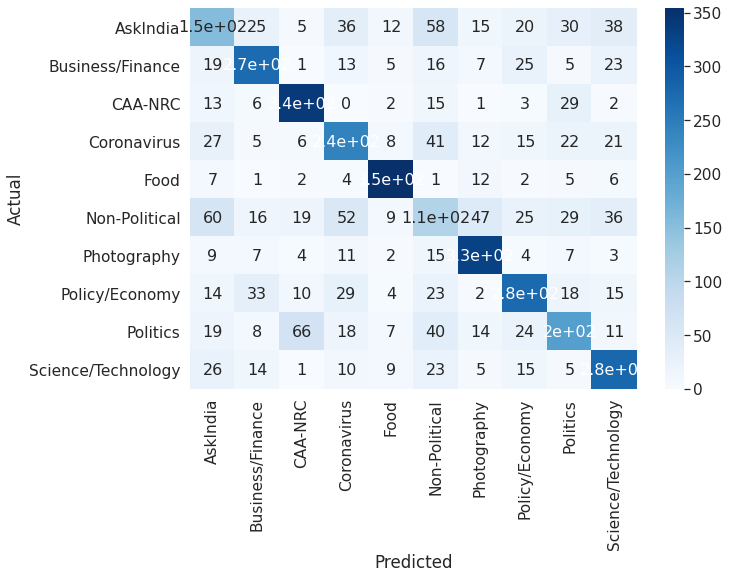

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np



data = confusion_matrix(test_y, predicted)
df_cm = pd.DataFrame(data, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})#

##### THE FOLLOWING GRAPHS SHOWS THE CONFUSION MATRIX OF THE ACTUAL RESULTS & PREDICTIONS

###  MULTINOMIAL NAIVE BAYES

I STARTED WITH NAIVE BAYES AS BASE MODEL FOR CLASSIFICATION. 
NAIVE BAYES IS A PROBABILISTIC APPROACH AND CONSIDERS EVERY FEATURE INDEPENDENT OF THE OTHER. 

In [51]:
clf = MultinomialNB().fit(X_tfidf,train_y)

In [52]:
Pkl_Filename = "Pickle_NB_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)

In [53]:
set_flair = []
for f in set(test_y):
    set_flair.append(f)

In [54]:
x_test_tf = cv.transform(test_x)
x_test_tfidf = tf.transform(x_test_tf)
predicted = clf.predict(x_test_tfidf)

In [55]:
print("accuracy : ", accuracy_score(test_y,predicted) )
print(metrics.classification_report(test_y,predicted , target_names = set_flair))
metrics.confusion_matrix(test_y , predicted)

accuracy :  0.62875
                    precision    recall  f1-score   support

          AskIndia       0.46      0.39      0.42       393
    Policy/Economy       0.61      0.72      0.66       387
       Photography       0.65      0.85      0.74       412
  Business/Finance       0.53      0.68      0.60       399
          Politics       0.80      0.90      0.85       394
       Coronavirus       0.45      0.16      0.23       403
Science/Technology       0.75      0.83      0.79       393
     Non-Political       0.64      0.63      0.64       424
           CAA-NRC       0.56      0.43      0.49       408
              Food       0.66      0.70      0.68       387

          accuracy                           0.63      4000
         macro avg       0.61      0.63      0.61      4000
      weighted avg       0.61      0.63      0.61      4000



array([[154,  40,  12,  52,  12,  24,  15,  20,  33,  31],
       [ 16, 277,   1,  14,  11,   6,   9,  28,   5,  20],
       [  9,  10, 352,   1,   4,   4,   3,   6,  22,   1],
       [ 23,  11,  16, 270,  10,  10,   8,  17,  16,  18],
       [ 13,   2,   1,  10, 354,   0,   6,   2,   2,   4],
       [ 59,  21,  35,  71,  15,  63,  44,  24,  38,  33],
       [  8,  12,   9,   9,  14,   3, 328,   2,   3,   5],
       [ 16,  47,  16,  32,   3,   8,   2, 269,  15,  16],
       [ 17,  11,  99,  26,   6,  16,  14,  31, 177,  11],
       [ 22,  24,   0,  20,  12,   6,   9,  19,   4, 271]])

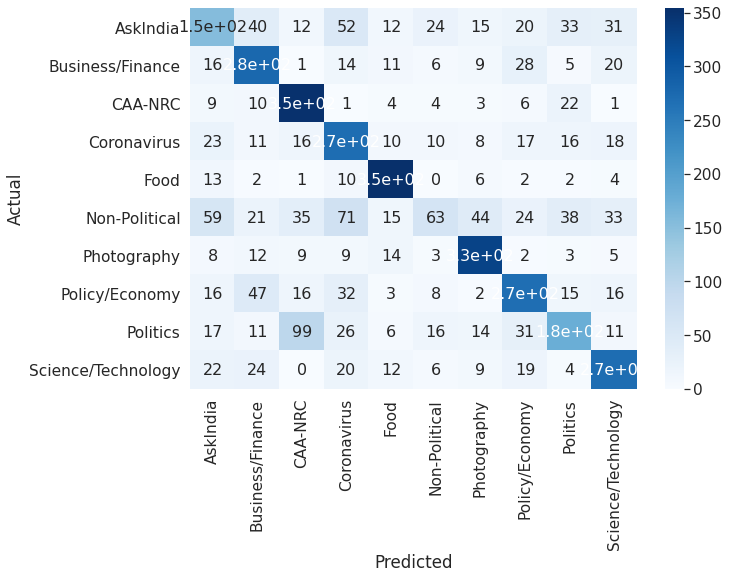

In [56]:
data = confusion_matrix(test_y, predicted)
df_cm = pd.DataFrame(data, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})#

##### THE FOLLOWING GRAPHS SHOWS THE CONFUSION MATRIX OF THE ACTUAL RESULTS & PREDICTIONS

### Linear SVM

SUPPORT VECTOR MACHINE IS A GEOMETRIC APPROACH AND CONSIDERS ALL FEATURES DEPENDENT TO EACH OTHER. HENCE , IT CONSIDERS THE RELATION BETWEEN DIFFERENT FEATURES & HENCE IMPROVING THE RESULT

In [57]:
lsvm = LinearSVC().fit(X_tfidf, train_y)

In [58]:
x_test_tf = cv.transform(test_x)
x_test_tfidf = tf.transform(x_test_tf)
predicted = lsvm.predict(x_test_tfidf)

In [59]:
print("accuracy : ", accuracy_score(test_y,predicted) )
print(metrics.classification_report(test_y,predicted , target_names = set_flair))
metrics.confusion_matrix(test_y , predicted)

accuracy :  0.67975
                    precision    recall  f1-score   support

          AskIndia       0.48      0.38      0.42       393
    Policy/Economy       0.75      0.82      0.78       387
       Photography       0.77      0.91      0.84       412
  Business/Finance       0.59      0.58      0.58       399
          Politics       0.89      0.96      0.92       394
       Coronavirus       0.33      0.25      0.29       403
Science/Technology       0.80      0.91      0.85       393
     Non-Political       0.72      0.76      0.74       424
           CAA-NRC       0.58      0.46      0.51       408
              Food       0.69      0.79      0.73       387

          accuracy                           0.68      4000
         macro avg       0.66      0.68      0.67      4000
      weighted avg       0.66      0.68      0.67      4000



array([[148,  26,   7,  41,   8,  56,  14,  20,  34,  39],
       [ 13, 316,   0,   7,   3,  11,   5,  17,   4,  11],
       [ 12,   2, 374,   0,   0,   7,   0,   4,  11,   2],
       [ 28,   9,   9, 230,   8,  43,   6,  22,  24,  20],
       [  2,   1,   0,   2, 377,   0,   2,   0,   2,   8],
       [ 58,  21,  21,  55,  11, 102,  36,  29,  35,  35],
       [  6,   1,   2,   5,   1,  11, 358,   1,   7,   1],
       [ 10,  18,   5,  18,   2,  24,   2, 321,  12,  12],
       [ 21,  17,  63,  21,   5,  42,  17,  23, 187,  12],
       [ 12,  10,   2,  13,   8,  16,   5,  10,   5, 306]])

In [60]:
Pkl_Filename = "Pickle_SVM_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(lsvm, file)

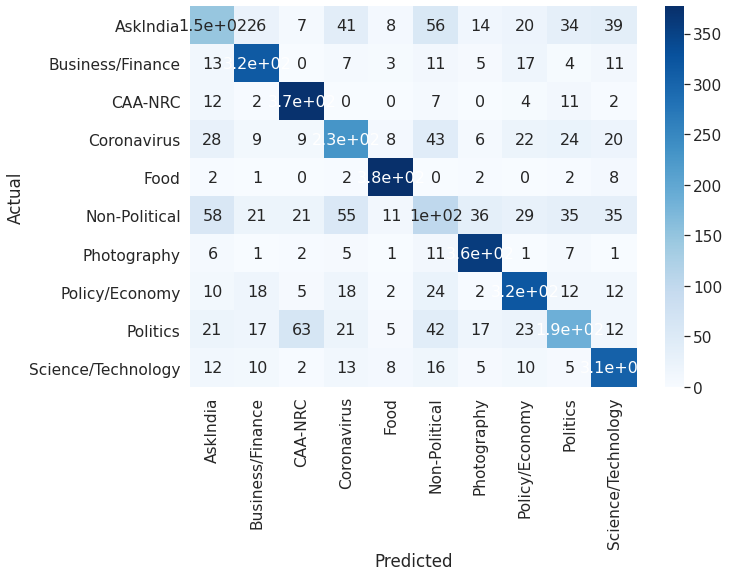

In [61]:
data = confusion_matrix(test_y, predicted)
df_cm = pd.DataFrame(data, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})#

##### THE FOLLOWING GRAPHS SHOWS THE CONFUSION MATRIX OF THE ACTUAL RESULTS & PREDICTIONS

### RANDOM FOREST MODEL

FOR EXPLAINABILITY AS RFC MODELS MEASURE THE WEIGHTAGE OF EACH WORD FOR EACH CLASS .  THEREFORE , ACCURACY OF THIS MODEL IS MANY TIMES BETTER.

In [62]:
cv = CountVectorizer()
rfc_x = cv.fit_transform(train_x)
rfc= RandomForestClassifier()
rfc.fit(rfc_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [63]:
x_test_tf = cv.transform(test_x)
predicted = rfc.predict(x_test_tf)
print("accuracy : ", accuracy_score(test_y,predicted) )
print(metrics.classification_report(test_y,predicted , target_names = set_flair))
metrics.confusion_matrix(test_y , predicted)

accuracy :  0.67675
                    precision    recall  f1-score   support

          AskIndia       0.43      0.37      0.40       393
    Policy/Economy       0.77      0.84      0.80       387
       Photography       0.73      0.92      0.81       412
  Business/Finance       0.58      0.57      0.58       399
          Politics       0.88      0.97      0.92       394
       Coronavirus       0.34      0.25      0.29       403
Science/Technology       0.78      0.90      0.83       393
     Non-Political       0.82      0.76      0.79       424
           CAA-NRC       0.51      0.42      0.47       408
              Food       0.72      0.79      0.75       387

          accuracy                           0.68      4000
         macro avg       0.66      0.68      0.66      4000
      weighted avg       0.66      0.68      0.66      4000



array([[147,  26,  24,  32,  10,  55,  20,  18,  27,  34],
       [ 17, 324,   2,   5,   4,  14,   4,   5,   6,   6],
       [  4,   2, 377,   0,   0,  10,   0,   1,  14,   4],
       [ 42,   5,   7, 226,   4,  47,  12,   7,  32,  17],
       [  0,   2,   2,   1, 382,   0,   0,   0,   4,   3],
       [ 67,  15,  24,  51,  17,  99,  42,  14,  49,  25],
       [  7,   1,   5,   6,   2,   7, 353,   0,  10,   2],
       [ 13,  17,  11,  20,   6,  11,   2, 321,  15,   8],
       [ 29,  11,  64,  33,   4,  32,  20,  22, 173,  20],
       [ 16,  18,   3,  13,   7,  13,   2,   4,   6, 305]])

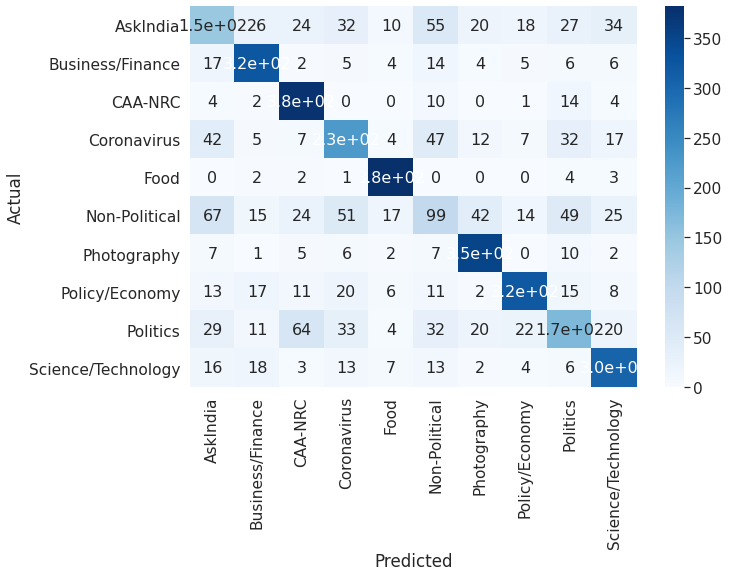

In [64]:
data = confusion_matrix(test_y, predicted)
df_cm = pd.DataFrame(data, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})#

##### THE FOLLOWING GRAPHS SHOWS THE CONFUSION MATRIX OF THE ACTUAL RESULTS & PREDICTIONS

In [65]:
Pkl_Filename = "Pickle_RFC_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(rfc, file)

####  I WILL BE USING NAIVE BAYES , LINEAR SVM , RANDOM FOREST FOR PREDICTING THE OUTPUT IN THE FINAL MODEL

#### I BUILT A HYBRID MODEL WHERE I CONSIDER THE PROBABILITY OF OUTPUT OF EACH MODEL & THE MODEL, WITH MOST PROBABILITY OR THE MODEL WHICH IS MOST CONFIDENT ABOUT THE OUTPUT . ONLY THAT MODEL'S OUPUT WOULD BE RETURED.

# LSTM LANGUAGE MODEL

#####  INSTEAD OF MAKING MY OWN EMBEDDINGS .
##### I PREFERED USING GLOVE EMBEDDINGS DEVELOPED BY STANFORD NLP WHICH WAS TRAINED ON MILLIONS OF DATA WHICH ENSURED A BETTER EMBEDDING.

In [66]:
file = "/home/aaryan/Documents/Research/ELMO 1/glove.6B.50d.txt"
import numpy as np
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    
     
    with open(gloveFile, encoding="utf8" ) as f:
        content = f.readlines()
    model = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
     
     
model= loadGloveModel(file)   
 
print (model['hello'])

Loading Glove Model
Done. 400000  words loaded!
[-0.38497   0.80092   0.064106 -0.28355  -0.026759 -0.34532  -0.64253
 -0.11729  -0.33257   0.55243  -0.087813  0.9035    0.47102   0.56657
  0.6985   -0.35229  -0.86542   0.90573   0.03576  -0.071705 -0.12327
  0.54923   0.47005   0.35572   1.2611   -0.67581  -0.94983   0.68666
  0.3871   -1.3492    0.63512   0.46416  -0.48814   0.83827  -0.9246
 -0.33722   0.53741  -1.0616   -0.081403 -0.67111   0.30923  -0.3923
 -0.55002  -0.68827   0.58049  -0.11626   0.013139 -0.57654   0.048833
  0.67204 ]


In [67]:
import csv 
words = pd.read_table(file, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
def vec(w):
    return words.loc[w].to_numpy()

 
print (vec('hello')) 

[-0.38497   0.80092   0.064106 -0.28355  -0.026759 -0.34532  -0.64253
 -0.11729  -0.33257   0.55243  -0.087813  0.9035    0.47102   0.56657
  0.6985   -0.35229  -0.86542   0.90573   0.03576  -0.071705 -0.12327
  0.54923   0.47005   0.35572   1.2611   -0.67581  -0.94983   0.68666
  0.3871   -1.3492    0.63512   0.46416  -0.48814   0.83827  -0.9246
 -0.33722   0.53741  -1.0616   -0.081403 -0.67111   0.30923  -0.3923
 -0.55002  -0.68827   0.58049  -0.11626   0.013139 -0.57654   0.048833
  0.67204 ]


In [68]:
#word_matrix = word.tonumpy()

##### TO BE USED GLOVE EMBEDDING FIRST HAS TO BE CONVERTED IN A FORM OF MATRIX :GLOVE WEIGHT MATRIX . WORD EMBEDDINGS OF EACH WORD IS SAVED IN THE MATRIX ACCORDING TO THEIR INDEXES IN THE DICTIONARY

In [69]:
matrix_len = len(word2index)
weights_matrix = np.zeros((matrix_len , 50))
words_found = 0

for i , word in enumerate(word2index):
    try:
        weights_matrix[i] = words.loc[str(word)] 
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6 , size = (weights_matrix.shape[1], ))

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [71]:
num_cases = df.shape[0]
num_cases

20000

#### STANDARD DATASET OF TEXT WITH LISTS ENLISTED WITH INDEXES OF OCCURING WORDS & SIMILAR LIST FOR FLAIRS.

In [72]:
x_dataset = np.zeros((num_cases , 10) , dtype = int)
y_dataset = np.zeros((num_cases), dtype = int)

for i , sentence in enumerate((df['title'])):
    for j , word in enumerate(sentence.split(' ')):
        if j < 10:
            x_dataset[i,j] = word2index[str(word)]
        else :
            break
    
for k, flair in enumerate(df['flair']):
    y_dataset[k] = flair2index[str(flair)]      
    

In [73]:
x_dataset = torch.tensor(x_dataset)
y_dataset = torch.tensor(y_dataset)

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size = 0.2, random_state = 0)

In [75]:
VOCAB_SIZE = weights_matrix.shape[0]
EMBEDDING_DIM = weights_matrix.shape[1]
HIDDEN_LAYER = 20

##### A LSTM LANGUAGE MODEL  BUILT IN PYTORCH FRAMEWORK . 
THE PRETRAINED GLOVE EMBEDDING WERE PASSED INTO THE MODEL IN THE FORM OF WEIGHT_MATRIX OR GLOVE WEIGHTS.
I HAD SOME PRE KNOWLEDGE THAT LSTM LANGUAGE MODELS WORKS BETTER ON TEXT AS COMPARED TO ML MODELS.
I USED RELU , SOFTMAX AS THE ACTIVATION LAYERS.

In [76]:
class LSTM_glove_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False #eze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim ,10)
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(0.35)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        output = self.linear(ht[-1])
        output = self.relu(output)
        output = self.linear1(output)
        output = self.softmax(output)
        
        return output

##### I USED ADAM OPTIMIZER TO BACK PROPOGATE & OPTIMIZE MY MODEL. I PREFERED ADAM BECAUSE IT IS MORE SENSETIVE TOWARDS THE HYPER PARAMETERS COMPARED TO SGD OPTIMIZERS. THE VALUES OF HYPERMATERS AFFECT OUR MODEL A LOT AS A LOT OF PROCESSING NEEDS TO BE DONE .

In [77]:
model = LSTM_glove_vecs(VOCAB_SIZE , EMBEDDING_DIM , HIDDEN_LAYER , weights_matrix)
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [78]:
x_train = torch.tensor(x_train)

/home/aaryan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [79]:
softmax_prob = model(x_train)

/home/aaryan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Cross Entropy loss minimizes the distance between the probability distributions therefore it is prefered for classification problems.

In [80]:
loss_function = torch.nn.CrossEntropyLoss()
total_loss = 0
losses =[]
epochs = 1
print_every = 1000

### TRAINING

##### THE MODEL TRAINS A BATCH OF VALUES AT A TIME. IN THIS SPECIFIC CASE , THE SIZE OF BATCH IS DECIDED AS 100

In [81]:
i = 0
x_train_data = np.zeros((100,50), dtype = int)
y_train_data = np.zeros(100,dtype = int)
for epoch in range(epochs):
    for i in range(x_train.shape[0]):
        y_train_data = y_train[i:i+100 ]
        x_train_data = x_train[i:i+100, :]
        i= i+100
        model.zero_grad()
        y_pred = model(x_train_data)
        loss = loss_function(y_pred, y_train_data)
        loss.backward()
        optimizer.step()
        total_loss =+ loss.item()
        if i% print_every == 0:
            print(str(loss.item()) + ' for ' + str(i))

/home/aaryan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



2.2912039756774902 for 1000
2.300973415374756 for 2000
2.341150999069214 for 3000
2.291171073913574 for 4000
2.3111510276794434 for 5000
2.331151008605957 for 6000
2.4111509323120117 for 7000
2.341150999069214 for 8000
2.3111510276794434 for 9000
2.3111510276794434 for 10000
2.2910964488983154 for 11000
2.341150999069214 for 12000
2.331151008605957 for 13000
2.4111509323120117 for 14000
2.3611509799957275 for 15000
2.3211510181427 for 16000


##### THE LOSS RATES DIDN'T IMPROVE MUCH
THE POSSIBLE REASONS CAN BE THE SHORTAGE OF DATA.
THERE MAY BE AN ISSUE WITH PARAMETERS.
I TRIED BOTH APPLYING GRADIENTS ON THE EMBEDDINGS AND FREEZING THEM BUT THE RESULTS WERE NOT SATISFACTORY.

#### ACCURACY OF THE MODEL

In [82]:
i = 0
accuracies = list()
x_test_data = np.zeros((100,50), dtype = int)
y_test_data = np.zeros(100,dtype = int)

for i in range(x_test.shape[0]):
    x_test_data = x_test[i:i+100,:]
    y_test_data = y_test[i:i+100]

    i = i + 100

    predictions, actuals,  = list(), list() 
    y_pred = model(x_test_data)
    y_pred = y_pred.detach().numpy()
    actual = y_test_data.numpy()
    y_pred = y_pred.round()
    predictions.append(y_pred)
    actuals.append(actual)
    predictions = np.array(predictions)

    actuals = np.array(actuals)
    b = np.zeros((actuals.size , 10))
    b[np.arange(actuals.size),actuals] = 1

    predictions_, actuals_ = np.vstack(predictions), np.vstack(b)
    acc = accuracy_score(actuals_, predictions_)
    acc=acc.astype(float)
    accuracies.append(acc)
    
    if i % 500 == 0:
        print(str(acc) + ' for ' + str(i))

/home/aaryan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



0.09 for 500
0.11 for 1000
0.09 for 1500
0.08 for 2000
0.14 for 2500
0.12 for 3000
0.14 for 3500
0.12 for 4000


In [83]:
accuracies = np.array(accuracies)

In [84]:
accuracies.mean()

0.11160216537549333

##### THE ACCURACY OF THE LSTM LANGUAGE MODEL WAS FOUND TO BE REALLY LOW.
AT LATER STAGES I REALISED THAT MY DATA WAS BIASED AND IT COULD BE A POSSIBLE REASON FOR THIS BUT IT DIDN'T IMPROVE EVEN AFTER BALANCING IT.
I ANALYSED IT AGAIN. I THOUGHT OF TWEAKING THE MODEL BY CHANGING THE OPTIMIZERS , LOSS FUNTIONS , SIZE OF HIDDEN LAYERS , BATCH SIZE , EPOCHS , LRs & EVEN DROPOUT RATES BUT I COULDN'T SEE MUCH DIFFERENCE IN THE RESULTS.
I BELIEVE THAT THE SIZE OF MY DATA WAS REALLY LOW COMPARED TO THE REQUIREMENTS AS SUCH NLP MODELS REQUIRE A LOTS OF TUNING .
ALSO ,A WILD GUESS CAN BE THAT I DID SOME ERROR WHILE USING GLOVE EMBEDDINGS.